# Electricity prices - as timeseries analysis

In [16]:
import os
print(f'Current working dir:\t {os.getcwd()}')
from pathlib import Path

from datetime import datetime
# from datetime import timedelta

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch

%matplotlib widget

Current working dir:	 c:\GitRepos\various-data-analysis\timeseries-analysis


In [17]:
filename = Path("Rocni_zprava_o_trhu_2020_V0.csv")
root_data = Path("C:/DATA_FAST/electricity")
# read only header first for prep on parsing and stuff
cols_from_header = pd.read_csv(root_data / filename, nrows=0).columns.tolist()
# # parse_dates = ['begins_at', 'ends_at', 'created_at', 'updated_at', 'expired_at', 'paid_at']
# # data_raw = pd.read_csv(filename, index_col='id', parse_dates=parse_dates).drop(columns=['payment_id'])
data_raw = pd.read_csv(root_data / filename, parse_dates=['Den']) #.drop(columns=['payment_id'])
data_raw = data_raw.dropna()
data_raw


,Den,Hodina,CZK/MWh
0,2020-01-01,1,843.61
1,2020-01-01,2,772.46
2,2020-01-01,3,724.95
3,2020-01-01,4,695.47
4,2020-01-01,5,670.32
...,...,...,...
8779,2020-12-31,20,1389.41
8780,2020-12-31,21,1324.32
8781,2020-12-31,22,1267.90
8782,2020-12-31,23,1252.41


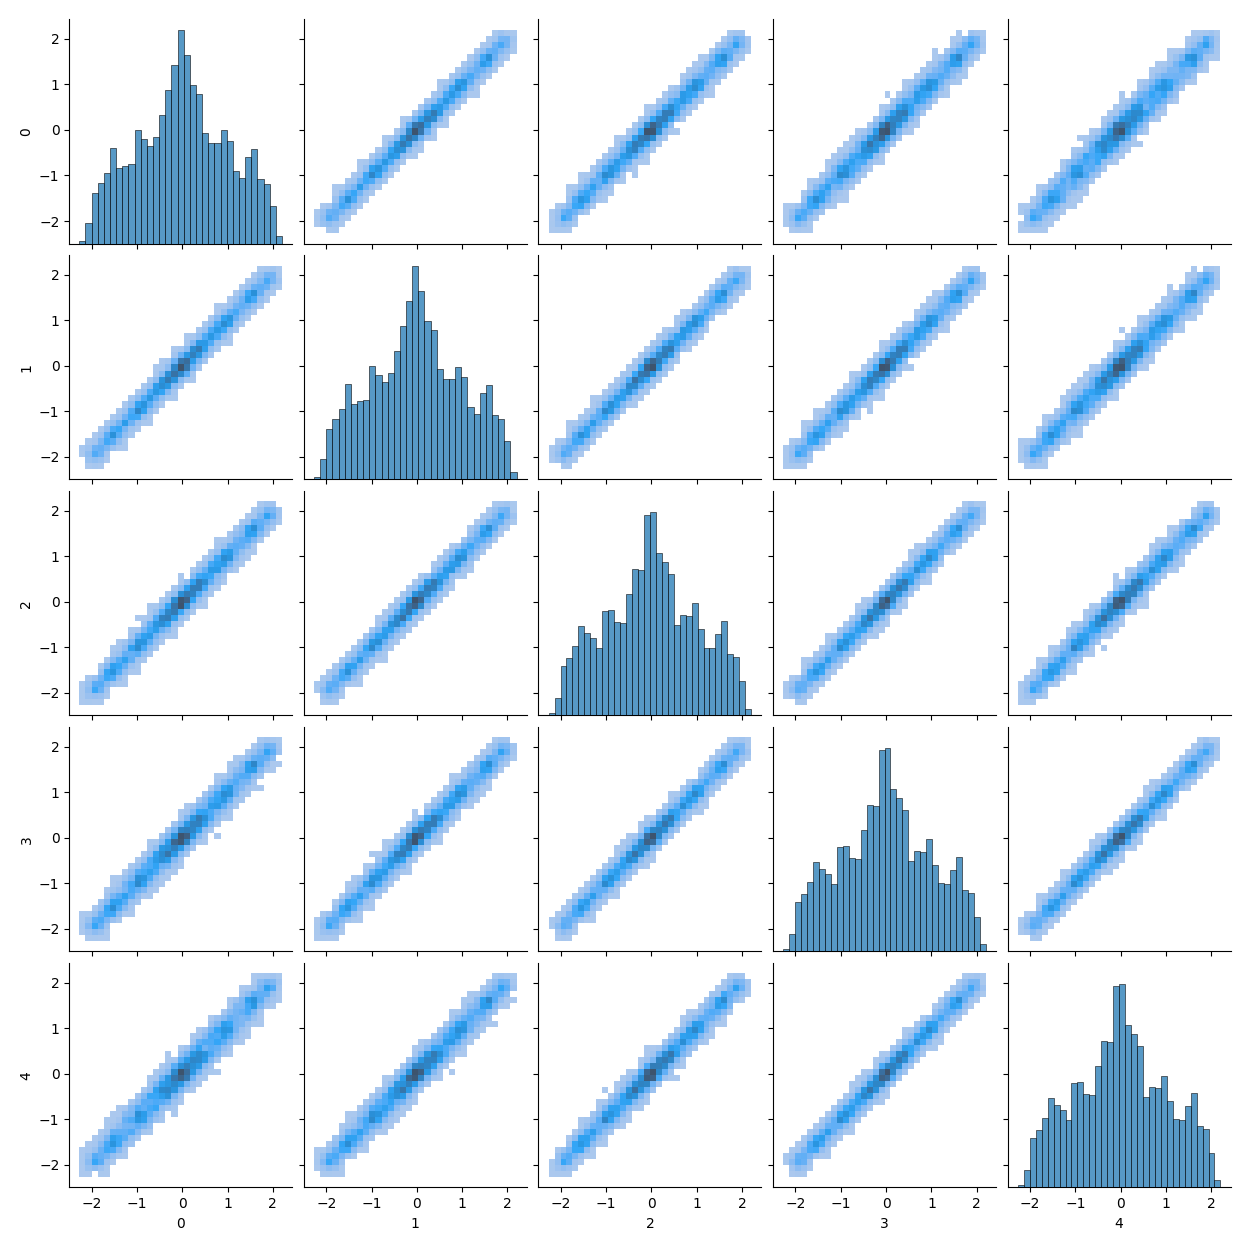

In [83]:
T = 100
N = 10000
t = torch.linspace(0, T, N)
prices = 0.1*torch.randn(N) + ( torch.sin(t) + torch.cos(5*t) )
# prices =( torch.sin(t) + torch.cos(5*t) ) * (torch.sin(t))
# prices = torch.tensor(data_raw['CZK/MWh'])
# prices = torch.tensor(data_raw['CZK/MWh'].diff())
windows = prices.unfold(0, 5, 1)
df2 = pd.DataFrame(windows.numpy())

# fig, ax = plt.subplots()
sns.pairplot(data=df2, kind='hist')

In [71]:
# prices = torch.tensor(data_raw['CZK/MWh'])
# prices = torch.tensor(data_raw['CZK/MWh'].diff())
windows = prices.unfold(0, 5, 1)
mean = windows.mean(dim=0, keepdim=True)
w_cov = (windows-mean).T.cov(correction=1)
Linv = torch.linalg.cholesky(w_cov).inverse()

windows_white = Linv@(windows-mean).T 
# windows_white.cov()
# windows_white.mean(dim=1)
print(Linv)

_LinAlgError: torch.linalg_cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 4 is not positive-definite).

In [86]:
# prices = torch.tensor(data_raw['CZK/MWh'])
# prices = torch.tensor(data_raw['CZK/MWh'].diff())
windows = prices.unfold(0, 15, 1)
mean = windows.mean(dim=0, keepdim=True)
w_cov = (windows-mean).T.cov(correction=1)
u, s, v = torch.linalg.svd(w_cov)

W = torch.diag(s.sqrt().reciprocal())@v
# windows_white = v.H@torch.diag(s.reciprocal())@(windows-mean).T 
windows_white = W@(windows-mean).T 
windows_white.cov().eig()
# windows_white.mean(dim=1)
# print(s)
# v.shape

torch.return_types.eig(
eigenvalues=tensor([[0.9990, 0.0000],
        [0.9992, 0.0000],
        [1.0010, 0.0000],
        [1.0009, 0.0000],
        [0.9996, 0.0000],
        [1.0007, 0.0000],
        [1.0006, 0.0000],
        [1.0005, 0.0000],
        [1.0003, 0.0000],
        [1.0002, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [0.9998, 0.0000],
        [0.9998, 0.0000],
        [1.0001, 0.0000]]),
eigenvectors=tensor([]))

tensor([[0.9990, 0.0000],
        [0.9992, 0.0000],
        [1.0010, 0.0000],
        [1.0009, 0.0000],
        [0.9996, 0.0000],
        [1.0007, 0.0000],
        [1.0006, 0.0000],
        [1.0005, 0.0000],
        [1.0003, 0.0000],
        [1.0002, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [0.9998, 0.0000],
        [0.9998, 0.0000],
        [1.0001, 0.0000]])

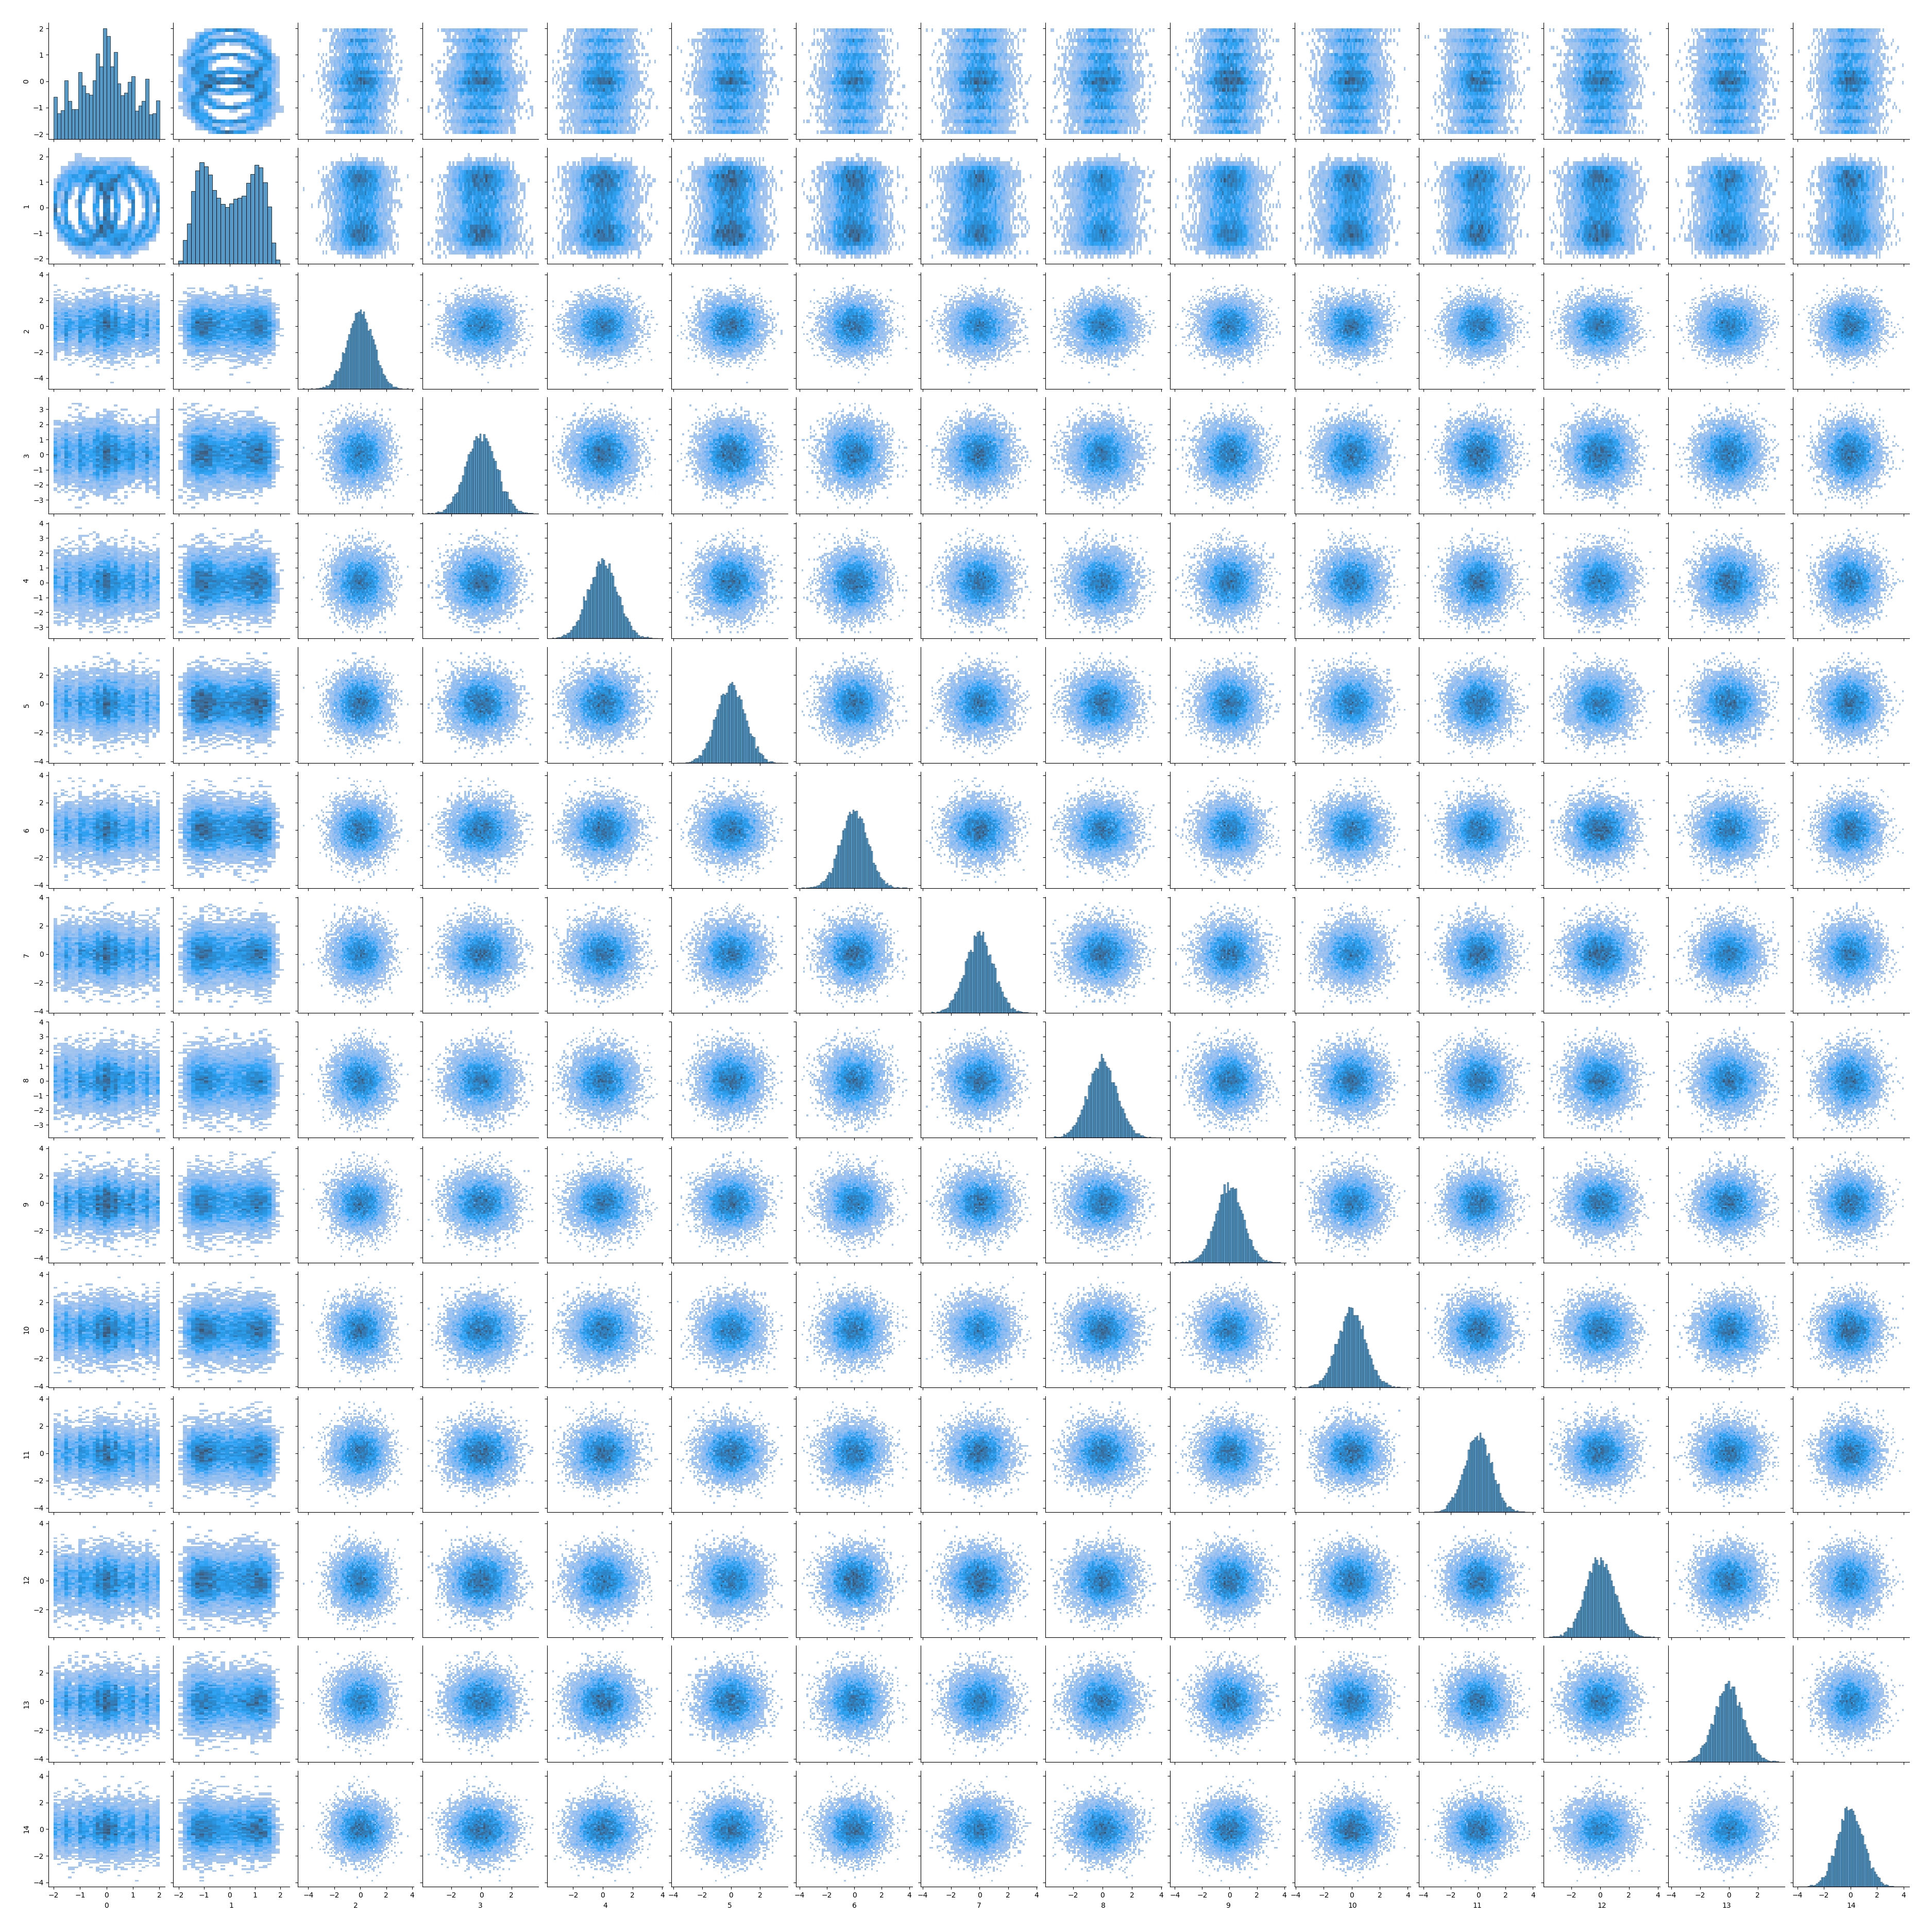

In [87]:
df_white = pd.DataFrame(windows_white.T.numpy())
df_white.shape

sns.pairplot(data=df_white, kind='hist')
# fig, ax = plt.subplots(1, 1, figsize=(16, 4))
# sns.ecdfplot(data=df_white, ax=ax)
# windows_white_cov = windows_white.T.cov()
evals, evecs = windows_white.cov().eig()
evals

<AxesSubplot:ylabel='Proportion'>

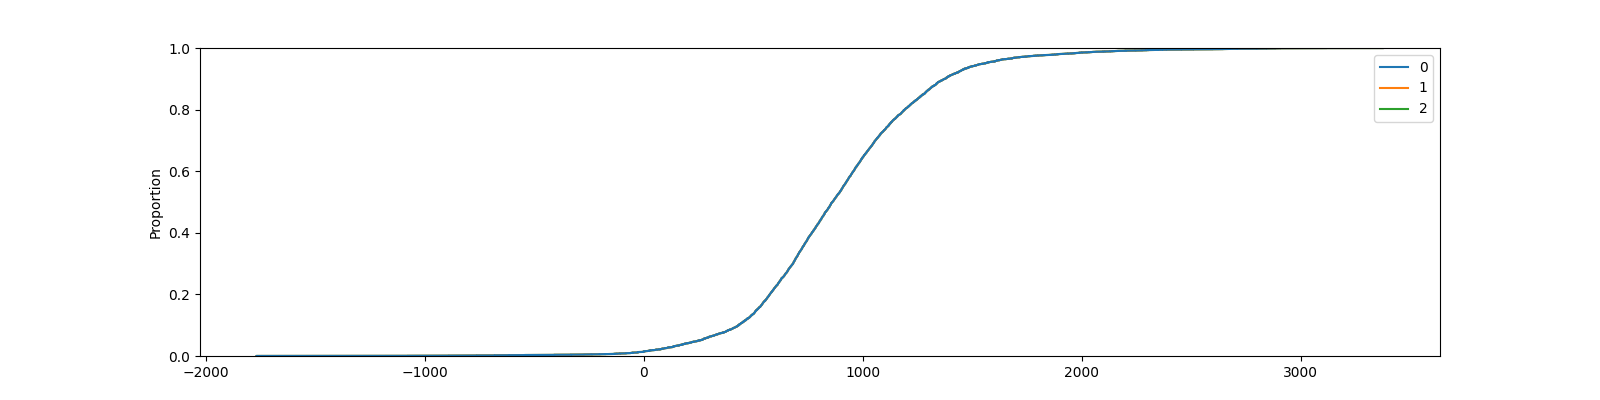

In [21]:
prices = torch.tensor(data_raw['CZK/MWh'])
# prices = torch.tensor(data_raw['CZK/MWh'].diff())
windows = prices.unfold(0, 3, 1)
w_cov = windows.cov()
u, s, v = torch.svd(windows - windows.mean(dim=0, keepdim=True))

df2 = pd.DataFrame(windows.numpy())

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
# sns.pairplot(data=df2, kind='hist')
sns.ecdfplot(data=df2, ax=ax)

In [22]:
torch.std_mean(windows, dim=0)

(tensor([421.8524, 421.8702, 421.8810], dtype=torch.float64),
 tensor([886.4735, 886.5201, 886.5677], dtype=torch.float64))

In [24]:
import torch.distributions as dist

In [28]:
d = mean.size(1)
mvn = dist.MultivariateNormal(loc=torch.zeros(d), covariance_matrix=torch.eye(d))

t = torch.linspace(-10, 10, 100)
y = mvn.cdf(t)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(t, y)

NotImplementedError: 